In [1]:
import sys
sys.path.insert(0, '../../../network')
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity 
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

### Initialization

In [2]:
params = np.load("./ctx_str_params.npz", allow_pickle=True) 
N, sequences, patterns, cp, cw, A = params['N'], params['sequences'], params['patterns'], params['cp'], params['cw'], params['A']

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8)

# populations
ctx = Population(N=N[0], tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=N[1], tau=1e-2, phi=phi, name='d1')
# d2 = Population(N=N[2], tau=1e-2, phi=phi, name='d2')

J = set_connectivity([ctx, d1], cp, cw, A, patterns, plasticity)
network = RateNetwork([ctx, d1], J, formulation=4, disable_pbar=False)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Building connections from ctx to d1
INFO:connectivity:Building connections from d1 to ctx
INFO:connectivity:Building connections from d1 to d1


### Simulation

In [4]:
init_inputs = [np.zeros(ctx.size),
               np.zeros(d1.size)]
input_patterns = [p[0] for p in patterns]

T=5 #ms
mouse = ReachingTask()
network.simulate_learning(mouse, T, init_inputs, input_patterns, plasticity, 
                          delta_t=300, eta=0.05, tau_e=800, lamb=0.3, 
                          noise=[0.13,0.13,0.13], a_cf=0, e_bl = [0.055,0.022,0.04,0.07], 
                          alpha=0.9, gamma=1, etrace=False, #[0.05,0.003,0.045,0.07]
                          hyper=False, r_ext=[lambda t:0, lambda t: .5], print_output=True)

INFO:network:Integrating network dynamics
  3%|▎         | 133/4999 [00:03<00:49, 98.52it/s]

null-->scavenge
0.0 0.0


  9%|▉         | 457/4999 [00:06<00:40, 112.72it/s]

scavenge-->aim
0.0 0.0


 15%|█▍        | 733/4999 [00:09<00:38, 111.69it/s]

aim-->lick
0.0 0.0


 20%|██        | 1020/4999 [00:11<00:35, 112.77it/s]

lick-->scavenge
0.0 0.0


 28%|██▊       | 1416/4999 [00:15<00:31, 112.94it/s]

scavenge-->aim
0.0 0.0


 34%|███▎      | 1680/4999 [00:17<00:29, 110.72it/s]

aim-->reach
0.0 0.0


 38%|███▊      | 1884/4999 [00:19<00:28, 110.48it/s]

reach-->lick
0.0 1.0
Mouse retrieved water


 43%|████▎     | 2172/4999 [00:21<00:25, 110.61it/s]

lick-->scavenge
0.0 0.0


 52%|█████▏    | 2592/4999 [00:25<00:21, 110.92it/s]

scavenge-->aim
0.0 0.0


 57%|█████▋    | 2866/4999 [00:28<00:19, 108.56it/s]

aim-->reach
0.0 0.9


 62%|██████▏   | 3082/4999 [00:30<00:17, 112.16it/s]

reach-->lick
0.9 1.0
Mouse retrieved water


 67%|██████▋   | 3334/4999 [00:32<00:14, 111.10it/s]

lick-->scavenge
0.0 0.0


 76%|███████▌  | 3778/4999 [00:36<00:10, 113.65it/s]

scavenge-->aim
0.0 0.81


 81%|████████  | 4054/4999 [00:39<00:08, 111.15it/s]

aim-->reach
0.81 0.99


 85%|████████▌ | 4258/4999 [00:41<00:06, 110.81it/s]

reach-->lick
0.99 1.0
Mouse retrieved water


 91%|█████████ | 4534/4999 [00:43<00:04, 111.18it/s]

lick-->scavenge
0.0 0.0


 99%|█████████▉| 4966/4999 [00:47<00:00, 112.36it/s]

scavenge-->aim
0.0 0.972


100%|██████████| 4999/4999 [00:48<00:00, 104.13it/s]


### Results

In [5]:
overlaps_ctx = sequences[0][0].overlaps(network.pops[0])
overlaps_d1 = sequences[1][0].overlaps(network.pops[1])
# overlaps_d2 = sequences[2][0].overlaps(network.pops[2])
# filename = 'learning-0005-1600-600-5-1000-v0'
# np.savez('./data/' + filename + '.npz', 
#          overlaps_ctx=overlaps_ctx, overlaps_bg=overlaps_bg, 
#          correlations_ctx=correlations_ctx, correlations_bg=correlations_bg, 
#          state_ctx=net_ctx.exc.state, state_bg=net_bg.exc.state)

INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 144.62it/s]
INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 199.21it/s]


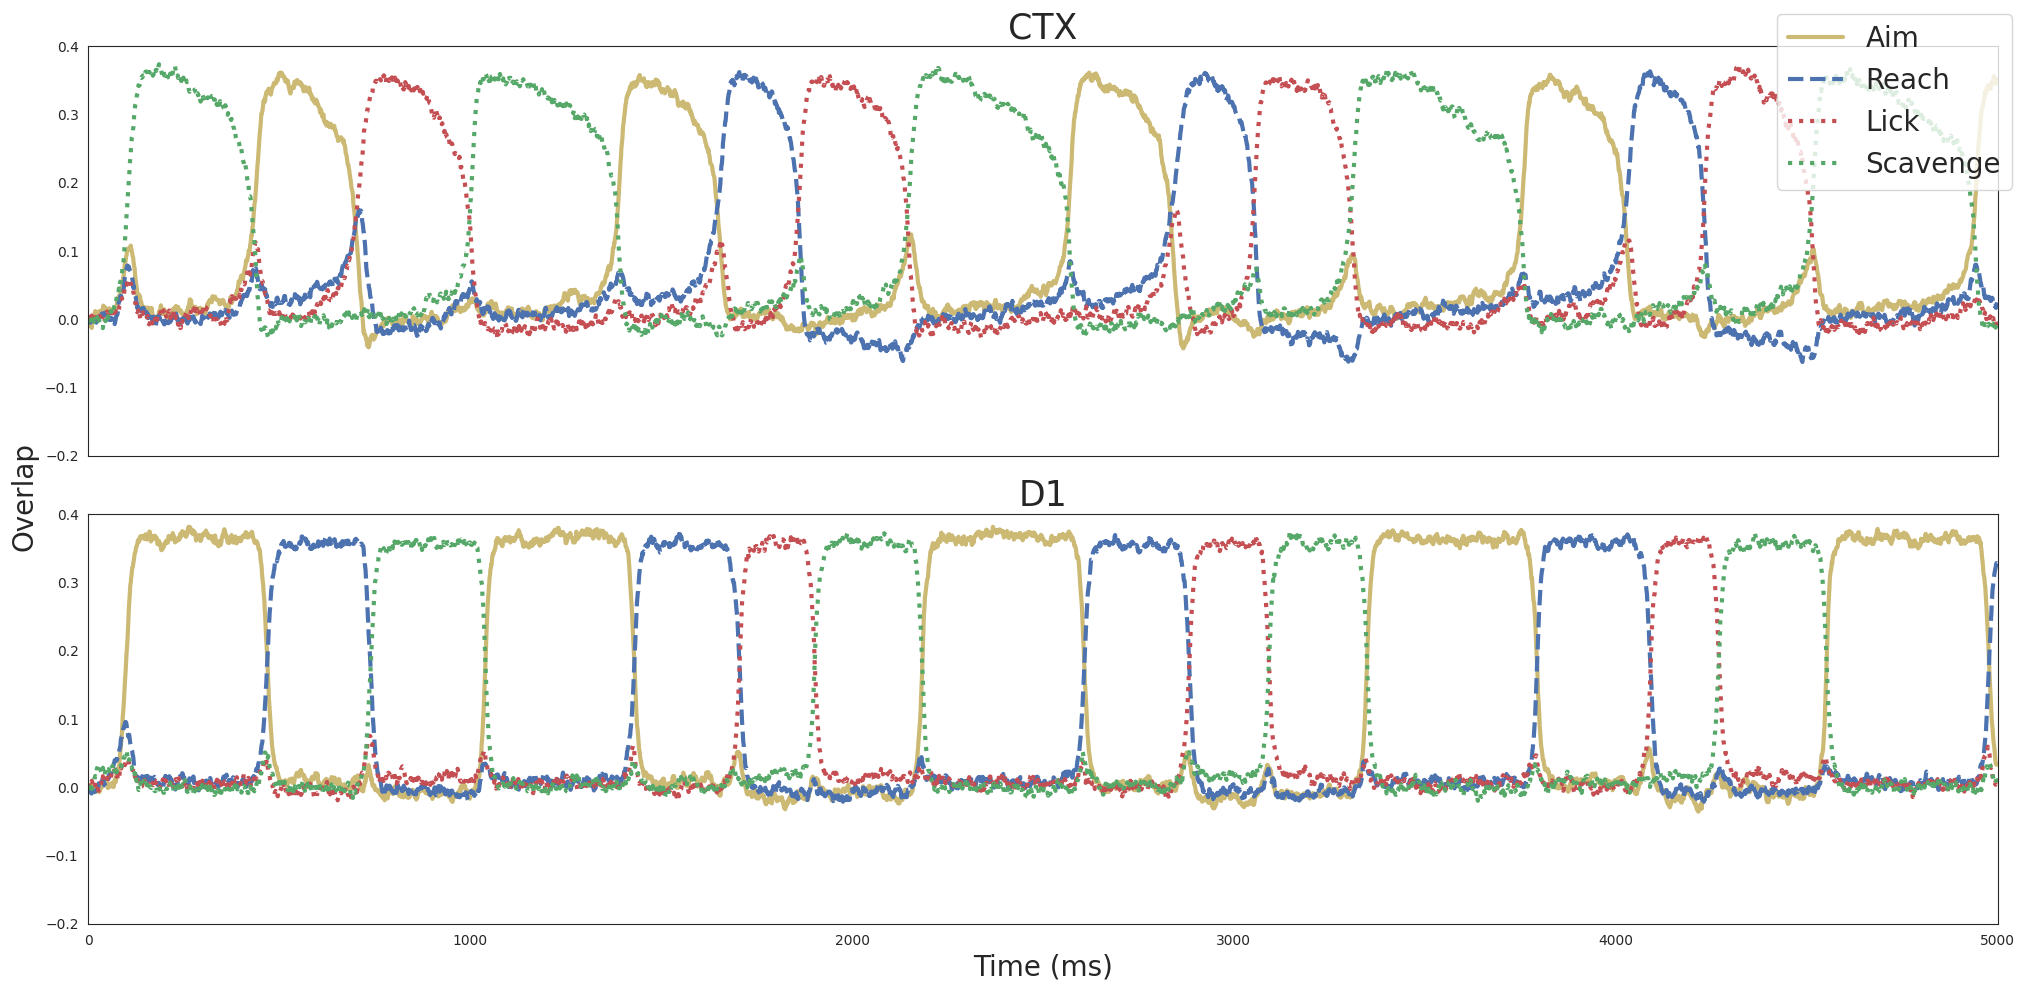

In [6]:
sns.set_style('white') 
colors = sns.color_palette('deep')

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, tight_layout=True, figsize=(20,10))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8], label='Aim')
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0], label='Reach')
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3], label='Lick')
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2], label='Scavenge')
# axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
# axes.set_xlabel('Time (ms)', fontsize=20)
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
# axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("D1", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
axes[1].set_xlabel('Time (ms)', fontsize=20)

fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 5000))
plt.setp(axes, ylim=(-.2, .4))
plt.figlegend(fontsize=20, loc='upper right')
# plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/simulation-env-pre-learning.jpg', bbox_inches = "tight", format='jpg')

plt.show()


In [7]:
def temporal_diff(A, B, max_iter):
    sum = 0
    cnt = 0
    for i in range(len(A)):
        if i == 0: continue
        if B[i+1] == None:
            break
        diff = B[i+1][1] - A[i][1]
        sum += (diff)
        cnt += 1
    return sum / cnt

temporal_diff(mouse.behaviors[0], mouse.behaviors[1], 100)

339.8125

/tmp/ipykernel_42829/2789246784.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


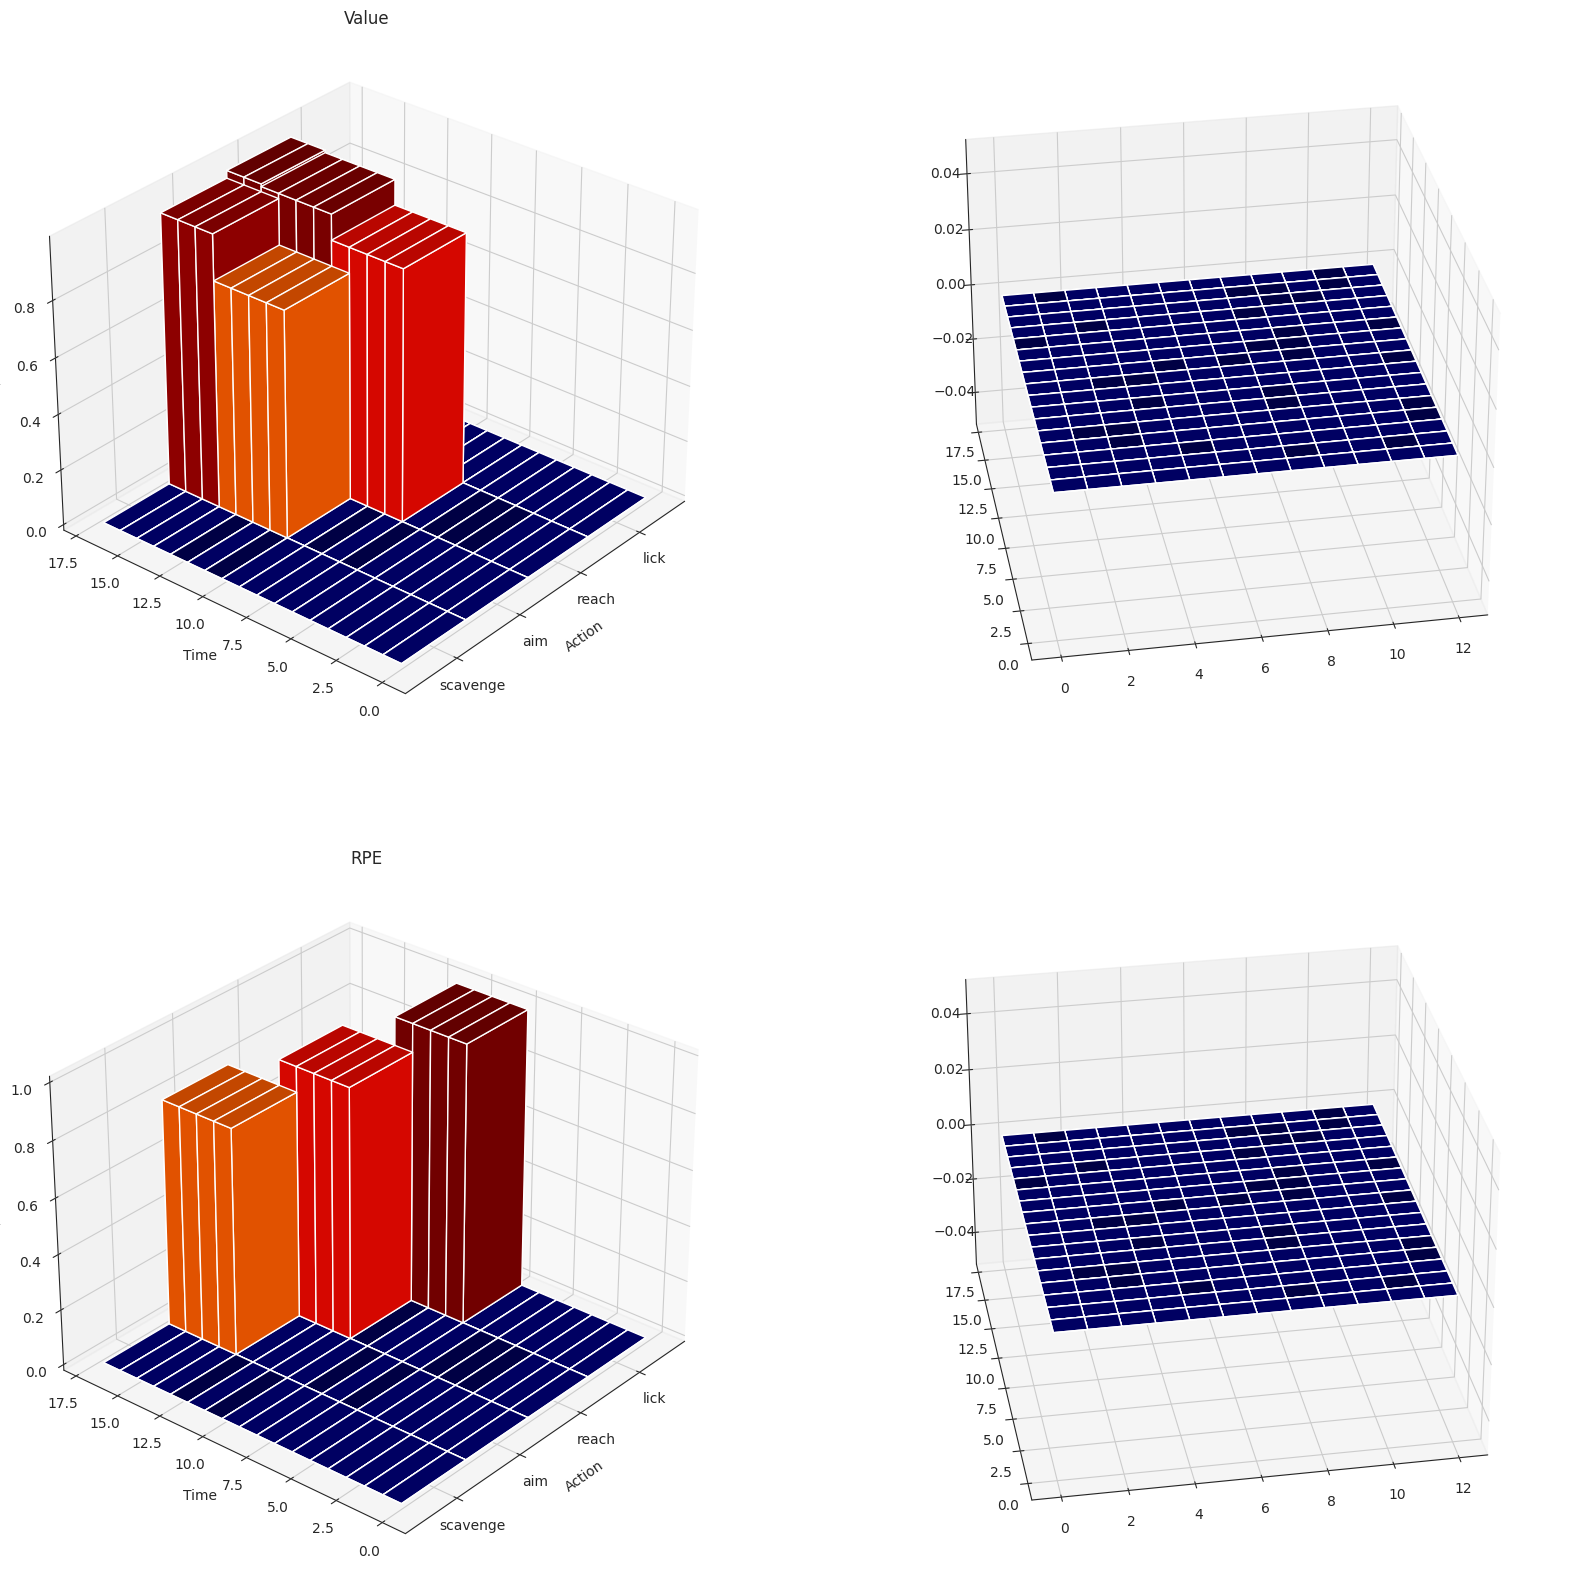

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def create_grid(len_x, len_y):
    _x, _y = np.arange(len_x), np.arange(len_y)
    _xx, _yy = np.meshgrid(_x, _y)
    return _xx.ravel(), _yy.ravel()

def plot_3d_bar(V, idxs):
    x, y = create_grid(len(idxs), V.shape[1])
    top = V[idxs,:].reshape(-1, order='F')
    bottom = np.zeros_like(top)
    width = depth = 1
    cmap = cm.get_cmap('jet')
    max_height = 1 
    min_height = 0
    rgba = [cmap((k-min_height)/max_height) for k in top] 
    
    return x, y, bottom, width, depth, top, rgba

x0, y0, b0, w0, d0, t0, color0 = plot_3d_bar(mouse.values, [3,4,9,10])
x1, y1, b1, w1, d1, t1, color1 = plot_3d_bar(mouse.values, [i for i in range(16) if i not in [3,4,9,10]])
x2, y2, b2, w2, d2, t2, color2 = plot_3d_bar(mouse.rpes, [3,4,9,10])
x3, y3, b3, w3, d3, t3, color3 = plot_3d_bar(mouse.rpes, [i for i in range(16) if i not in [3,4,9,10]])

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')
column_names = ['scavenge', 'aim', 'reach', 'lick']
ticksx = np.array([0.5, 1.5, 2.5, 3.5])
ax1.set_xticks(ticksx, column_names)
ax1.bar3d(x0, y0, b0, w0, d0, t0, shade=True, color=color0)
ax1.set_title('Value')
ax1.set_xlabel('Action')
ax1.set_ylabel('Time')
ax1.set_zlabel('V')
ax1.set_xticks(ticksx, column_names)
ax1.view_init(30, -140)
ax2.bar3d(x1, y1, b1, w1, d1, t1, shade=True, color=color1)
ax2.view_init(30, -100)
ax3.set_xticks(ticksx, column_names)
ax3.bar3d(x2, y2, b2, w2, d2, t2, shade=True, color=color2)
ax3.set_title('RPE')
ax3.set_xlabel('Action')
ax3.set_ylabel('Time')
ax3.set_zlabel('V')
ax3.set_xticks(ticksx, column_names)
ax3.view_init(30, -140)
ax4.bar3d(x3, y3, b3, w3, d3, t3, shade=True, color=color3)
ax4.view_init(30, -100)
plt.savefig('/work/jp464/striatum-sequence/output/RPE-simulation.jpg', bbox_inches = "tight", format='jpg')
plt.show()
